In [511]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import math

from matplotlib.lines import Line2D
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import ConvexHull
from scipy import interpolate
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.neighbors import KernelDensity
from sklearn.metrics.cluster import rand_score
from sklearn.decomposition import PCA

In [512]:
warnings.simplefilter(action='ignore', category=FutureWarning)
df = pd.read_csv("new.csv",header=0, index_col=0)
pd.set_option('mode.chained_assignment', None)

In [513]:
df.shape

(5243, 164)

In [514]:
df.columns

Index(['pl_name', 'hostname', 'pl_letter', 'hd_name', 'hip_name', 'tic_id',
       'gaia_id', 'sy_snum', 'sy_pnum', 'sy_mnum',
       ...
       'sy_tmag', 'sy_tmag_reflink', 'sy_kepmag', 'sy_kepmag_reflink',
       'pl_nnotes', 'st_nphot', 'st_nrvc', 'st_nspec', 'pl_nespec',
       'pl_ntranspec'],
      dtype='object', length=164)

In [515]:
df = df[['pl_name','sy_snum',
'sy_pnum',
'sy_mnum',
'pl_orbper',
'pl_orbsmax',
'pl_rade',
'pl_radj',
'pl_bmasse',
'pl_bmassj',
'pl_dens',
'pl_orbeccen',
'pl_insol',
'pl_eqt',
'pl_orbincl',
'pl_trandep',
'pl_ratdor',
'pl_orbtper',
'pl_orblper',
'st_spectype',
'st_teff',
'st_rad',
'st_mass',
'st_lum',
'st_logg',
'st_age',
'st_dens',
'st_vsin',
'st_rotp',
'st_radv',
'cb_flag']]

In [516]:
df.shape

(5243, 31)

In [517]:
df.isnull().sum().to_frame()

,0
pl_name,0
sy_snum,0
sy_pnum,0
sy_mnum,0
pl_orbper,191
pl_orbsmax,286
pl_rade,17
pl_radj,18
pl_bmasse,23
pl_bmassj,23


In [518]:
df2 = df.pivot_table(index = ['pl_name'], aggfunc ='size')


In [519]:
df2

pl_name
11 Com b      1
11 UMi b      1
14 And b      1
14 Her b      1
16 Cyg B b    1
             ..
ups And b     1
ups And c     1
ups And d     1
ups Leo b     1
xi Aql b      1
Length: 5243, dtype: int64

In [520]:
num_of_duplicates = len(df) - len(df.drop_duplicates())
num_of_duplicates

0

In [521]:
all_columns = df.columns
all_columns

Index(['pl_name', 'sy_snum', 'sy_pnum', 'sy_mnum', 'pl_orbper', 'pl_orbsmax',
       'pl_rade', 'pl_radj', 'pl_bmasse', 'pl_bmassj', 'pl_dens',
       'pl_orbeccen', 'pl_insol', 'pl_eqt', 'pl_orbincl', 'pl_trandep',
       'pl_ratdor', 'pl_orbtper', 'pl_orblper', 'st_spectype', 'st_teff',
       'st_rad', 'st_mass', 'st_lum', 'st_logg', 'st_age', 'st_dens',
       'st_vsin', 'st_rotp', 'st_radv', 'cb_flag'],
      dtype='object')

In [522]:
col_will_drop = []

for i in all_columns:
    if df[i].isnull().sum() > 1000:
        col_will_drop.append(i)

col_will_drop

['pl_insol',
 'pl_eqt',
 'pl_orbincl',
 'pl_trandep',
 'pl_ratdor',
 'pl_orbtper',
 'pl_orblper',
 'st_spectype',
 'st_age',
 'st_vsin',
 'st_rotp',
 'st_radv']

In [523]:
df = df.drop(columns = col_will_drop)
df.columns

Index(['pl_name', 'sy_snum', 'sy_pnum', 'sy_mnum', 'pl_orbper', 'pl_orbsmax',
       'pl_rade', 'pl_radj', 'pl_bmasse', 'pl_bmassj', 'pl_dens',
       'pl_orbeccen', 'st_teff', 'st_rad', 'st_mass', 'st_lum', 'st_logg',
       'st_dens', 'cb_flag'],
      dtype='object')

#### Getting the amount of missing columns per row

In [524]:
s = df.set_index('pl_name').isna().groupby('pl_name').sum().sum(axis=1)
for i in df['pl_name']:
    df.loc[df['pl_name'] == i,'empty_col_count'] = s[i]


In [525]:
df.head()

,pl_name,sy_snum,sy_pnum,sy_mnum,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_dens,pl_orbeccen,st_teff,st_rad,st_mass,st_lum,st_logg,st_dens,cb_flag,empty_col_count
rowid,,,,,,,,,,,,,,,,,,,,
1,11 Com b,2,1,0,326.030000,1.290000,12.1,1.08,6165.60000,19.40000,19.10,0.231000,4742.0,19.00,2.70,2.243,2.31,NaN,0,1.0
2,11 UMi b,1,1,0,516.219970,1.530000,12.3,1.09,4684.81420,14.74000,13.80,0.080000,4213.0,29.79,2.78,2.430,1.93,NaN,0,1.0
3,14 And b,1,1,0,185.840000,0.830000,12.9,1.15,1525.50000,4.80000,3.90,0.000000,4813.0,11.00,2.20,1.763,2.63,NaN,0,1.0
4,14 Her b,1,2,0,1765.038901,2.773069,12.6,1.12,2586.74645,8.13881,7.11,0.372689,5338.0,0.93,0.91,-0.153,4.45,1.27393,0,0.0
5,16 Cyg B b,3,1,0,798.500000,1.660000,13.5,1.20,565.73740,1.78000,1.26,0.680000,5750.0,1.13,1.08,0.097,4.36,1.01103,0,0.0


In [526]:
"""def get_empty_col(row_index):
    total_nan = 0
    for col in df.columns:
        if pd.isna(df[col][row_index]):
            total_nan += 1
    return total_nan"""

'def get_empty_col(row_index):\n    total_nan = 0\n    for col in df.columns:\n        if pd.isna(df[col][row_index]):\n            total_nan += 1\n    return total_nan'

#### Find the number of empty columns per row, append it to the dataframe

In [527]:
"""df['empty_col_count'] = 0
for i in df.index:
    df['empty_col_count'][i] = get_empty_col(i)"""

"df['empty_col_count'] = 0\nfor i in df.index:\n    df['empty_col_count'][i] = get_empty_col(i)"

In [528]:
print('Max:\t', df['empty_col_count'].max())
print('Min:\t',df['empty_col_count'].min())
print('Total:\t',len(df.columns))

Max:	 9.0
Min:	 0.0
Total:	 20


In [529]:
df = df[df['empty_col_count'] < 5]
df.shape

(5063, 20)

In [530]:
df.isnull().sum().to_frame()

,0
pl_name,0
sy_snum,0
sy_pnum,0
sy_mnum,0
pl_orbper,40
pl_orbsmax,275
pl_rade,7
pl_radj,8
pl_bmasse,16
pl_bmassj,16


In [531]:
label_df = df['pl_name']
df = df.drop(['pl_name','empty_col_count'], axis=1)
label_df.head()

rowid
1      11 Com b
2      11 UMi b
3      14 And b
4      14 Her b
5    16 Cyg B b
Name: pl_name, dtype: object

### **Imputation**

In [532]:
scaler = MinMaxScaler()
df.apply(np.abs)
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns, index=df.index)
df.head(10)

,sy_snum,sy_pnum,sy_mnum,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_dens,pl_orbeccen,st_teff,st_rad,st_mass,st_lum,st_logg,st_dens,cb_flag
rowid,,,,,,,,,,,,,,,,,,
1,0.333333,0.000000,0.0,8.105728e-07,0.000171,0.153207,0.153331,0.025797,0.025798,0.014783,0.510438,0.073850,0.173504,0.246112,0.842568,0.165179,NaN,0.0
2,0.000000,0.000000,0.0,1.283682e-06,0.000203,0.155803,0.154786,0.019602,0.019601,0.010675,0.407623,0.064475,0.272088,0.253431,0.861476,0.108631,NaN,0.0
3,0.000000,0.000000,0.0,4.618415e-07,0.000110,0.163591,0.163515,0.006383,0.006383,0.003000,0.353151,0.075109,0.100411,0.200366,0.794034,0.212798,NaN,0.0
4,0.000000,0.142857,0.0,4.390197e-06,0.000369,0.159697,0.159150,0.010823,0.010823,0.005488,0.606913,0.084413,0.008406,0.082342,0.600303,0.483631,0.006757,0.0
5,0.666667,0.000000,0.0,1.985871e-06,0.000220,0.171378,0.170788,0.002367,0.002367,0.000954,0.816159,0.091715,0.010233,0.097896,0.625581,0.470238,0.005358,0.0
6,0.000000,0.000000,0.0,1.438309e-06,0.000192,0.163591,0.163515,0.005745,0.005745,0.002698,0.394005,0.063482,0.236729,0.110704,0.843680,0.074405,NaN,0.0
7,0.333333,0.000000,0.0,2.470448e-06,0.000346,0.158399,0.157696,0.013697,0.013697,0.007116,0.407623,0.078051,0.077570,0.209515,0.777755,0.241071,NaN,0.0
8,0.000000,0.000000,0.0,NaN,0.043964,0.238182,0.238289,0.012552,0.010638,0.001946,NaN,0.061763,0.011878,0.076853,0.578362,0.416667,0.002042,0.0
9,0.000000,0.000000,0.0,7.505194e-08,0.000025,0.176570,0.176608,0.001210,0.001210,0.000436,0.381749,0.076526,0.097122,0.089661,0.795147,0.181548,NaN,0.0


In [533]:
imputer = KNNImputer(n_neighbors=70)
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns, index = df.index)

In [534]:
df.isnull().sum().to_frame()

,0
sy_snum,0
sy_pnum,0
sy_mnum,0
pl_orbper,0
pl_orbsmax,0
pl_rade,0
pl_radj,0
pl_bmasse,0
pl_bmassj,0
pl_dens,0


In [535]:
df.shape

(5063, 18)

### **Habitable Zone Calculations**

In [536]:
df = pd.DataFrame(scaler.inverse_transform(df), columns = df.columns, index=df.index)
df_habitable_zone = df.copy()

In [537]:
df_habitable_zone = df_habitable_zone[["pl_orbsmax","st_rad","st_teff"]]
df_habitable_zone["st_rad_meters"] = df_habitable_zone["st_rad"]*6.957*10**8
df_habitable_zone["st_rad_squared"]=df_habitable_zone["st_rad_meters"]**2
df_habitable_zone["st_teff_power4"]=df_habitable_zone["st_teff"]**4
df_habitable_zone['st_luminosity'] = df_habitable_zone.apply(lambda row: 4*math.pi*row.st_rad_squared*5.67*10**(-8)*row.st_teff_power4, axis = 1)

In [538]:
df_habitable_zone["st_luminosity_reduced"] = df_habitable_zone["st_luminosity"]/(3.828*10**26)

In [539]:
df_habitable_zone["st_luminosity_reduced_sqrt"] = df_habitable_zone["st_luminosity_reduced"]**(1/2)
df_habitable_zone["min_distance"] = df_habitable_zone["st_luminosity_reduced_sqrt"]*0.95
df_habitable_zone["max_distance"] = df_habitable_zone["st_luminosity_reduced_sqrt"]*1.37

In [540]:
bigger_than_min = df_habitable_zone[df_habitable_zone['pl_orbsmax']>df_habitable_zone['min_distance']]
in_the_zone = bigger_than_min[bigger_than_min['pl_orbsmax']<bigger_than_min['max_distance']]
in_the_zone

,pl_orbsmax,st_rad,st_teff,st_rad_meters,st_rad_squared,st_teff_power4,st_luminosity,st_luminosity_reduced,st_luminosity_reduced_sqrt,min_distance,max_distance
rowid,,,,,,,,,,,
32,0.77080,0.94,5172.0,653958000.0,4.276611e+17,7.155402e+14,2.180352e+26,0.569580,0.754705,0.716970,1.033946
49,0.78000,0.86,4864.0,598302000.0,3.579653e+17,5.597244e+14,1.427605e+26,0.372938,0.610686,0.580152,0.836640
56,0.83000,0.81,5004.0,563517000.0,3.175514e+17,6.270024e+14,1.418653e+26,0.370599,0.608768,0.578330,0.834013
60,0.78000,0.90,5012.0,626130000.0,3.920388e+17,6.310216e+14,1.762650e+26,0.460463,0.678574,0.644645,0.929646
65,0.43500,0.69,4324.0,480033000.0,2.304317e+17,3.495769e+14,5.739550e+25,0.149936,0.387216,0.367855,0.530486
...,...,...,...,...,...,...,...,...,...,...,...
4869,0.14500,0.31,3430.0,215667000.0,4.651225e+16,1.384129e+14,4.587085e+24,0.011983,0.109467,0.103993,0.149970
4942,0.16330,0.42,3459.0,292194000.0,8.537733e+16,1.431536e+14,8.708388e+24,0.022749,0.150828,0.143287,0.206635
4966,0.02925,0.12,2566.0,83484000.0,6.969578e+15,4.335374e+13,2.152911e+23,0.000562,0.023715,0.022529,0.032490


In [541]:
df['pl_zone_flag'] = 0
df.loc[in_the_zone.index,'pl_zone_flag'] = 1
df.loc[in_the_zone.index]

,sy_snum,sy_pnum,sy_mnum,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_dens,pl_orbeccen,st_teff,st_rad,st_mass,st_lum,st_logg,st_dens,cb_flag,pl_zone_flag
rowid,,,,,,,,,,,,,,,,,,,
32,2.0,5.0,0.0,259.880000,0.77080,7.590,0.677,44.81200,0.14100,0.563000,0.0800,5172.0,0.94,0.91,-0.197,4.43,1.41851,0.0,1
49,1.0,1.0,0.0,268.940000,0.78000,13.800,1.230,330.54320,1.04000,0.691000,0.2900,4864.0,0.86,0.49,-0.320,4.26,1.73113,0.0,1
56,1.0,1.0,0.0,307.880000,0.83000,13.600,1.210,432.24663,1.36000,0.944000,0.1200,5004.0,0.81,0.81,-0.399,4.22,2.22951,0.0,1
60,1.0,1.0,0.0,265.590000,0.78000,14.000,1.250,228.83645,0.72000,0.458000,0.2700,5012.0,0.90,0.91,-0.313,4.09,1.66486,0.0,1
65,1.0,2.0,0.0,125.940000,0.43500,8.380,0.747,53.00000,0.17000,0.495000,0.3100,4324.0,0.69,0.70,-1.022,4.74,2.74700,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4869,1.0,1.0,0.0,35.189346,0.14500,2.194,0.196,5.45000,0.01710,2.840000,0.4960,3430.0,0.31,0.33,-1.867,4.97,15.80000,0.0,1
4942,1.0,4.0,0.0,37.423960,0.16330,1.073,0.096,1.25000,0.00394,5.560000,0.0420,3459.0,0.42,0.42,-1.640,4.81,7.86000,0.0,1
4966,1.0,7.0,0.0,6.101013,0.02925,0.920,0.082,0.69200,0.00218,4.901605,0.0051,2566.0,0.12,0.09,-3.257,5.24,75.05000,0.0,1


In [542]:
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns, index=df.index)

In [543]:
df.columns

Index(['sy_snum', 'sy_pnum', 'sy_mnum', 'pl_orbper', 'pl_orbsmax', 'pl_rade',
       'pl_radj', 'pl_bmasse', 'pl_bmassj', 'pl_dens', 'pl_orbeccen',
       'st_teff', 'st_rad', 'st_mass', 'st_lum', 'st_logg', 'st_dens',
       'cb_flag', 'pl_zone_flag'],
      dtype='object')

In [544]:
df.shape

(5063, 19)

#### Separating columns related to planets or stars for further analysis

In [545]:
df_planets = df.loc[:,df.columns.str.startswith('pl')].copy() # for clustering only planet data
df_stellar = df.loc[:,df.columns.str.startswith('st')].copy() # for clustering only stellar data

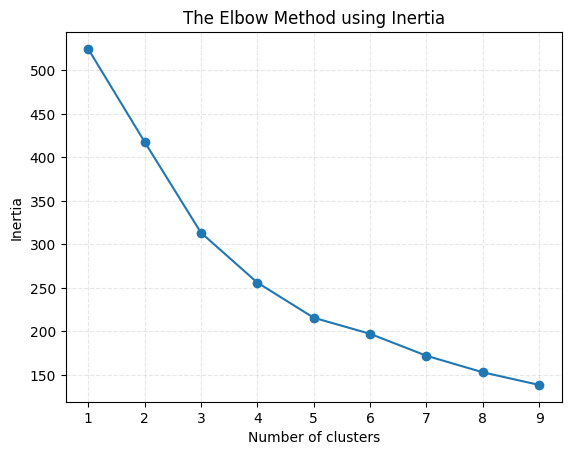

In [546]:
inertias = []
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(df)
    kmeanModel.fit(df)
    inertias.append(kmeanModel.inertia_)

plt.plot(K, inertias, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()

#### Performing PCA on default attributes

In [547]:
pca_data = PCA()
reduced_data = pca_data.fit_transform(df)
results_df = pd.DataFrame(reduced_data,index = df.index)
results_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
rowid,,,,,,,,,,,,,,,,,,,
1,-0.237722,0.084123,0.407884,-0.062819,0.213346,-0.105260,-0.156250,0.124228,0.010564,0.030663,0.011392,0.018765,-0.015802,0.004515,0.015518,0.000006,0.000060,0.000003,-2.590172e-21
2,-0.232469,-0.002857,0.208603,-0.313193,0.266511,-0.004958,-0.107081,0.203493,-0.007275,0.046676,0.007915,0.016291,0.030887,0.000330,-0.013294,-0.000097,-0.000762,-0.000013,-7.554284e-19
3,-0.198698,-0.018309,0.132628,-0.215044,0.210355,0.000035,-0.005326,0.094261,-0.007261,-0.007259,-0.005807,-0.010279,-0.025093,0.001374,0.032812,-0.000458,-0.000081,-0.000004,5.401759e-17
4,-0.021617,0.045603,0.124381,-0.102211,-0.179691,0.023909,0.017729,-0.023366,-0.005334,0.002165,-0.001071,0.004791,0.002435,0.002018,-0.010342,-0.001157,-0.000455,-0.000004,4.447242e-20
5,-0.204442,0.213354,0.563789,0.323515,-0.195706,-0.187940,-0.150411,-0.041749,0.016846,-0.002749,0.000589,0.000598,0.001448,-0.001668,-0.007926,-0.000242,-0.000469,-0.000006,8.421998e-20


In [548]:
exp_var_pca_data = pca_data.explained_variance_ratio_
exp_var_pca_data

array([2.85485227e-01, 2.11174564e-01, 1.54300296e-01, 1.14813020e-01,
       7.74323346e-02, 5.77222565e-02, 4.31796356e-02, 1.64590862e-02,
       1.37230091e-02, 7.64051965e-03, 4.40979398e-03, 4.28269433e-03,
       3.65913784e-03, 2.82556258e-03, 2.43442752e-03, 4.57660322e-04,
       7.68465705e-07, 6.05617110e-09, 5.58855975e-36])